# Predict log EC50s of Dual-Agonist Peptides using Convolutional Neural Network

The example in this paper is adapted from the following paper:

Puszkarska, A.M., Taddese, B., Revell, J. et al. Machine learning designs new GCGR/GLP-1R dual agonists with enhanced biological potency. Nat. Chem. (2024)

Here is the link to its original github repository [PeptideModels](https://github.com/amp91/PeptideModels)

This paper aims to design dual-agonists peptides targeting human GCG and GLP-1 receptors. The loss function of the original model contains the MSE loss of peptide-GCGR log EC50 and the MSE loss of peptide-GLP-1R log EC50, for the purpose of multi-task learning.

In [ ]:
!pip install wget seaborn tqdm

## Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

mpl.rcParams["font.size"] = 24
mpl.rcParams["lines.linewidth"] = 2

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


## Download & Load Dataset

In [ ]:
!python -m wget https://raw.githubusercontent.com/xuhuihuang/uwmadisonchem361/refs/heads/main/CNN_training_data.csv \
--output CNN_training_data.csv

In [ ]:
filename = "CNN_training_data.csv"
df = pd.read_csv(filename)
df


Saved under CNN_training_data (4).csv


,pep_ID,EC50_T1,EC50_LOG_T1,EC50_T2,EC50_LOG_T2,Aligned_Sequence
0,seq_pep1,3.75,-11.43,563.00,-9.25,HSQGTFTSDYSKYLDSRRAQDFVQWLEEGE
1,seq_pep2,18.50,-10.73,552.00,-9.26,HSQGTFTSDYSKYLDSRRAEDFVQWLENGE
2,seq_pep3,3.51,-11.45,252.00,-9.60,HSQGTFTSDYSKYLDSRRAEDFVQWLENT-
3,seq_pep4,50.50,-10.30,6.03,-11.22,HSQGTFTSDYSKYLDSRRAEDFVQWLVAGG
4,seq_pep5,2.87,-11.54,238.00,-9.62,HSQGTFTSDYSKYLDSRRAQDFVQWLEAEG
...,...,...,...,...,...,...
120,seq_pep121,29000.00,-7.54,9.62,-11.02,HGEGTFTSDVSSYMERQSVDEFIAWLLKGR
121,seq_pep122,29400.00,-7.53,7.94,-11.10,HGEGTFTSDVSSYMESQLVDEFIAWLLKGR
122,seq_pep123,29500.00,-7.53,29500.00,-7.53,HGEGTFTSDVSSYMEPQSTDEFIAWLLKGR
123,seq_pep124,29200.00,-7.53,598.00,-9.22,HGEGTFTSDVSSYMDFQSLVEFLAWLLKGR


## Create PyTorch Dataset

#### Convert sequence to onehot embedding

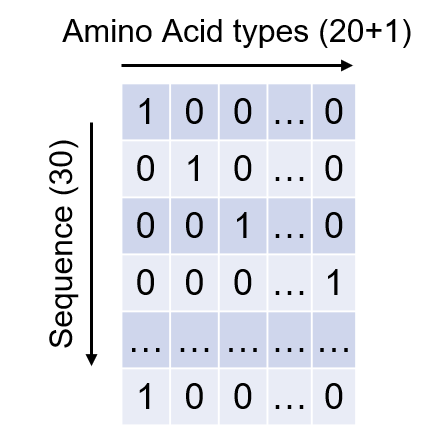

In [5]:
def seq2onehot(sequence):
    AMINOACIDS = 'ACDEFGHIKLMNPQRSTVWY'
    onehot = np.zeros((len(sequence), len(AMINOACIDS)+1))
    aa_to_idx = {aa: idx for idx, aa in enumerate(AMINOACIDS)}
    for i, aa in enumerate(sequence):
        if aa in aa_to_idx:
            onehot[i, aa_to_idx[aa]] = 1
        else:
            onehot[i, -1] = 1
    return onehot

In [6]:
seq = df.iloc[0]["Aligned_Sequence"]
print("Peptide sequence:", seq)
onehot = seq2onehot(seq)
print("Onehot Embedding:")
print(onehot)

Peptide sequence: HSQGTFTSDYSKYLDSRRAQDFVQWLEEGE
Onehot Embedding:
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1

In [7]:
class PeptideDataset(Dataset):
    def __init__(self, df, encoder,
                 seq_col="Aligned_Sequence", target_cols=("EC50_LOG_T1", "EC50_LOG_T2")):
        self.df = df
        self.encoder = encoder
        self.seq_col = seq_col
        self.target_cols = target_cols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sequence = row[self.seq_col]
        onehot_sequence = self.encoder(sequence)
        onehot_sequence = np.transpose(onehot_sequence)
        label = [row[col] for col in self.target_cols]
        return torch.tensor(onehot_sequence, dtype=float), torch.tensor(label, dtype=float).reshape(1, -1)

## Split Dataset

In [8]:
from sklearn.model_selection import train_test_split

# training/validation dataset
data_size = df.shape[0]
test_ratio = 0.10
test_size = int(data_size*test_ratio)
train_indices, test_indices = train_test_split(range(data_size), test_size=test_size, shuffle=True)
print(f"Training size: {len(train_indices)}, test size: {len(test_indices)}")
train_df, test_df = df.iloc[train_indices], df.iloc[test_indices]

Training size: 113, test size: 12


In [9]:
# create dataloaders
batch_size = 10
encoder = seq2onehot
train_data = PeptideDataset(train_df, encoder=encoder)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           shuffle=True, drop_last=False)
test_data = PeptideDataset(test_df, encoder=encoder)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=False, drop_last=False)

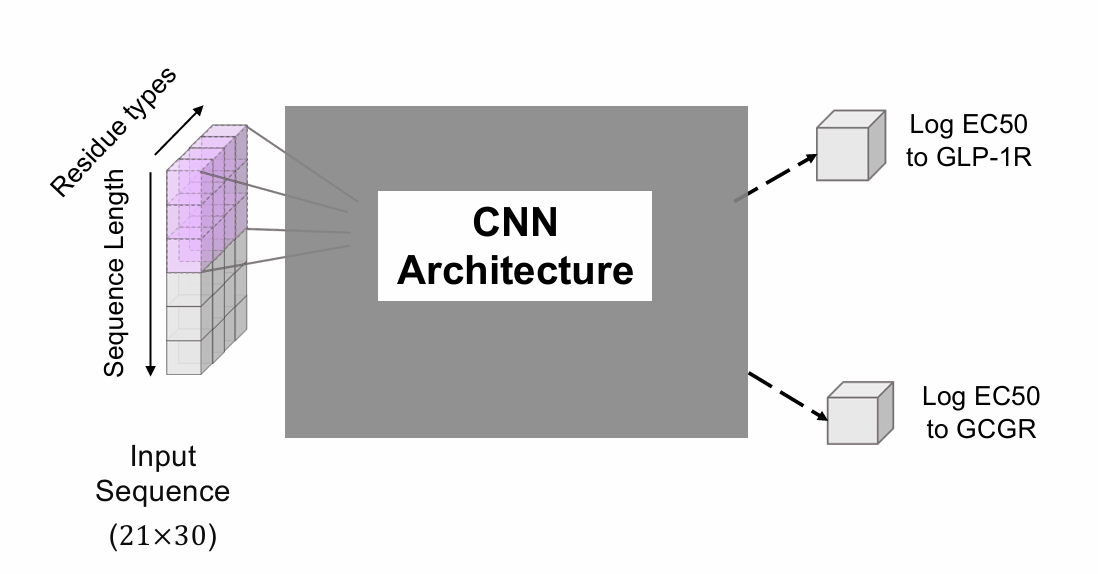

In [10]:
## uncomment the block to see one datapoint
# train_data[0]
x, y = train_data[0]
print("Shape of one datapoint:", x.shape)
print("Shape of one label:", y.shape)

Shape of one datapoint: torch.Size([21, 30])
Shape of one label: torch.Size([1, 2])


## CNN Model

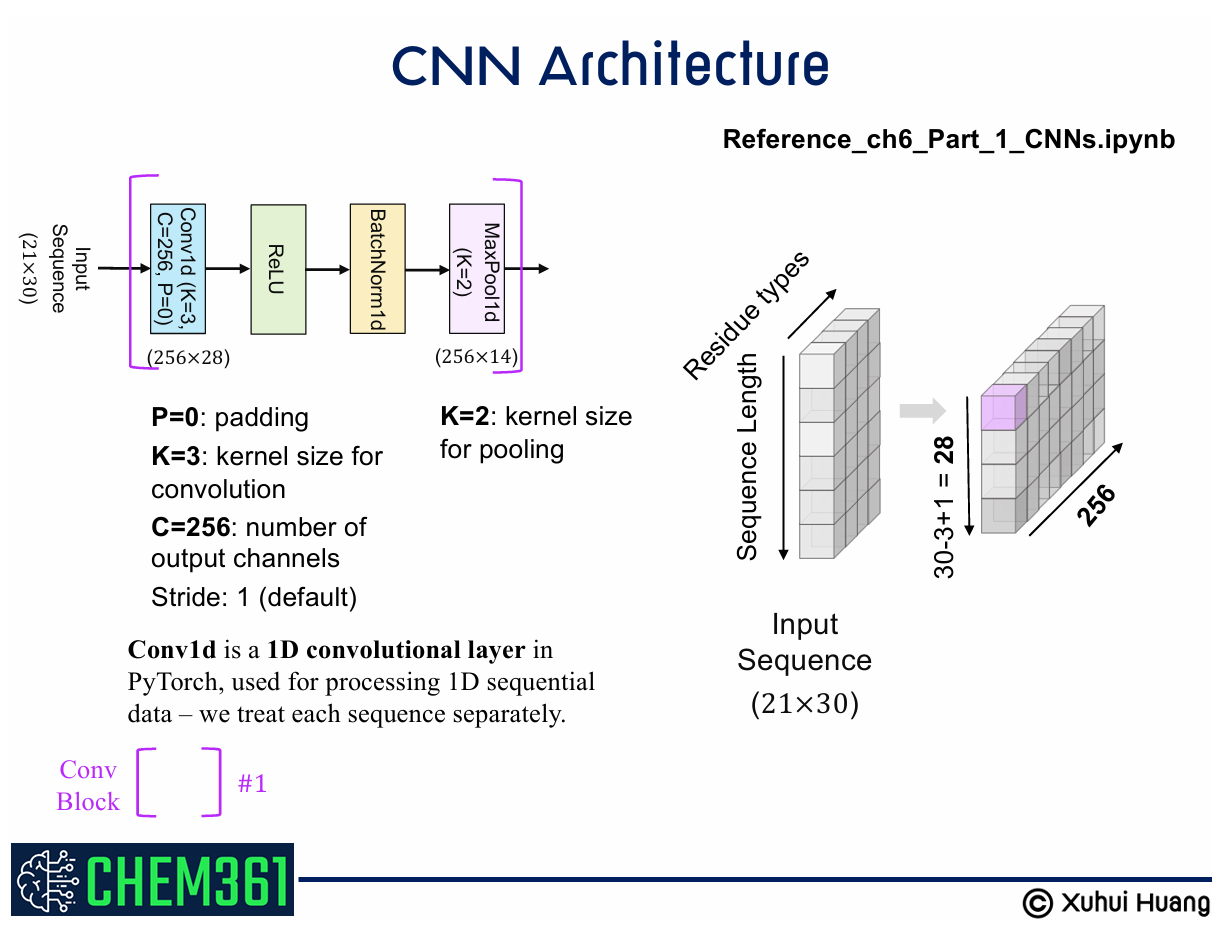

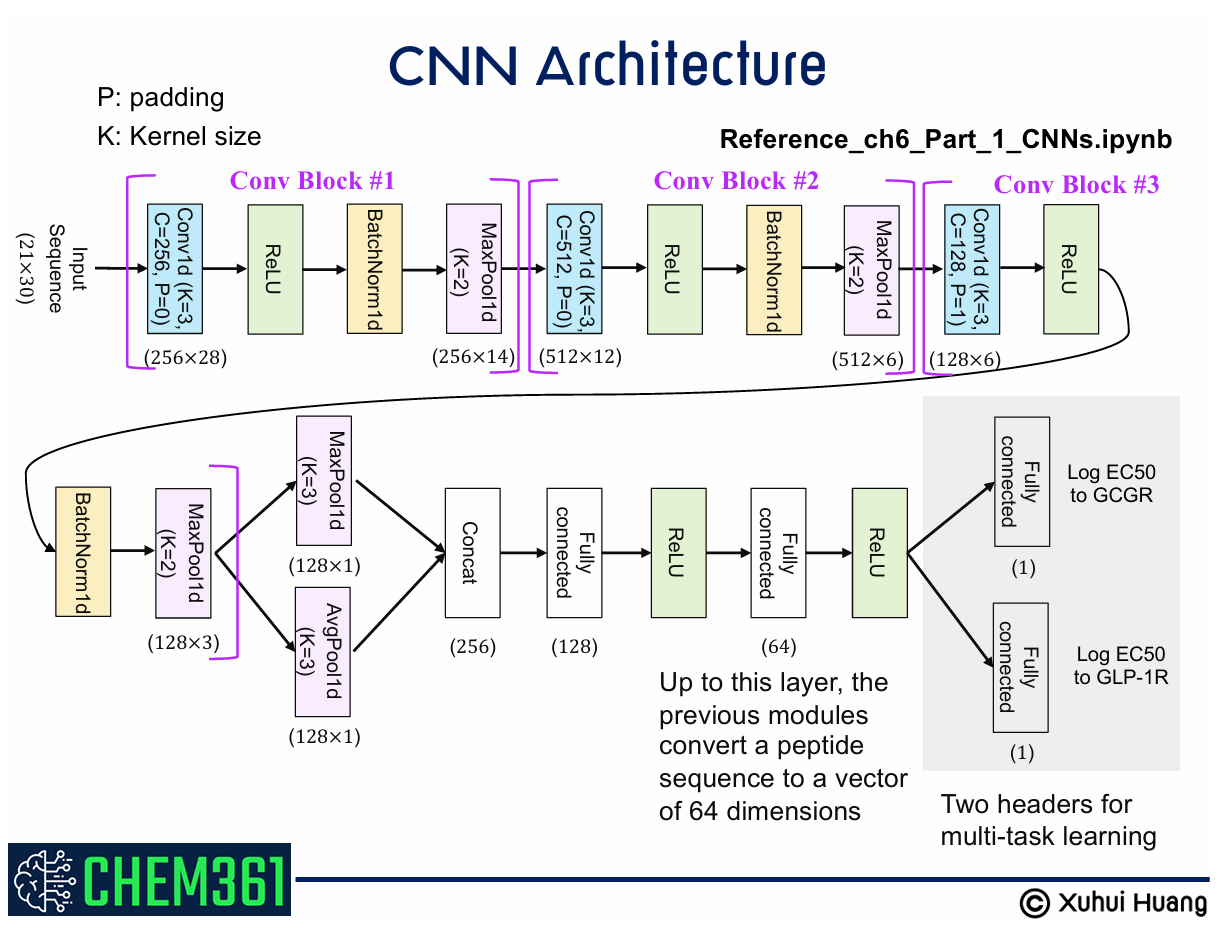

In [11]:
class BaseModel(nn.Module):

    def __init__(self, in_shape, dropout=0.3):
        super().__init__()

        # Defining NN layers in Conv Block #1
        in_channels = in_shape[0]
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels=256, kernel_size=3, stride=1, padding=0, bias=False),
            nn.ReLU(),
        )
        self.bn1 = nn.BatchNorm1d(num_features=256)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.dropout1 = nn.Dropout1d(p=dropout)

         # Defining NN layers in Conv Block #2
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=0, bias=False),
            nn.ReLU(),
        )
        self.bn2 = nn.BatchNorm1d(num_features=512)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.dropout2 = nn.Dropout1d(p=dropout)

        # Defining NN layers in Conv Block #3
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=512, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
        )
        self.bn3 = nn.BatchNorm1d(num_features=128)
        self.pool3 = nn.MaxPool1d(kernel_size=2)
        self.dropout3 = nn.Dropout1d(p=dropout)

        #Explore the diemnsion in order to concatenate the data later
        self._dummy_input_shape = (1, in_channels, in_shape[1])
        self.dummy_input = torch.randn(self._dummy_input_shape)
        self.flattened_size = self._calculate_flattened_size()

        self.dropout = nn.Dropout1d(p=dropout)

        # Defining fully connected layer (128 hidden neurons)
        self.dense1 = nn.Sequential(
            nn.Linear(in_features=self.flattened_size, out_features=128, bias=True),
            nn.ReLU(),
        )

        # Defining fully connected layer (64 hidden neurons)
        self.dense2 = nn.Sequential(
            nn.Linear(in_features=128, out_features=64, bias=True),
            nn.ReLU(),
        )

    def forward(self, input_seqs):
        # Calling NN layers in Cov Block #1
        x = self.dropout1(self.pool1(self.bn1(self.conv1(input_seqs))))
        # Calling NN layers in Cov Block #2
        x = self.dropout2(self.pool2(self.bn2(self.conv2(x))))
        # Calling NN layers in Cov Block #3
        x = self.dropout3(self.pool3(self.bn3(self.conv3(x))))

        # Pooling and concatenate the data
        length = x.shape[-1]
        max_pool = nn.MaxPool1d(kernel_size=length)(x).squeeze(-1)
        avg_pool = nn.AvgPool1d(kernel_size=length)(x).squeeze(-1)
        x = torch.cat([max_pool, avg_pool], dim=-1)

        # Calling the dense NN layer #1
        x = self.dropout(self.dense1(x))
        # Calling the dense NN layer #2
        x = self.dropout(self.dense2(x))

        return x

    def _calculate_flattened_size(self):
        """Pass dummy data through the network to get the flattened size."""
        with torch.no_grad():
            x = self.dummy_input
            x = self.dropout1(self.pool1(self.bn1(self.conv1(x))))
            x = self.dropout2(self.pool2(self.bn2(self.conv2(x))))
            x = self.dropout3(self.pool3(self.bn3(self.conv3(x))))

            # max pooling and average pooling layer here turn each 30-residude peptide into a single dimension.
            # 128*1: "128" can be traced back to the original 20+1 type of amino acides
            # while "1" refers to a whole peptide in order to predict properties of whole peptides
            length = x.shape[-1]
            max_pool = nn.MaxPool1d(kernel_size=length)(x).squeeze(-1)
            avg_pool = nn.AvgPool1d(kernel_size=length)(x).squeeze(-1)
            x = torch.cat([max_pool, avg_pool], dim=-1)
        return x.shape[1]


class MultiHeadModel(nn.Module):

    def __init__(self, in_shape, dropout=0.3):
        super().__init__()

        self.base_model = BaseModel(in_shape=in_shape, dropout=dropout)
        self.head_1 = nn.Linear(in_features=64, out_features=1, bias=True)
        self.head_2 = nn.Linear(in_features=64, out_features=1, bias=True)

    def forward(self, input_seqs):

        base_out = self.base_model(input_seqs)
        out_1 = self.head_1(base_out)
        out_2 = self.head_2(base_out)

        return torch.cat([out_1, out_2], dim=1)

In [12]:
def train_one_epoch(model, criterion, optimizer, dataloader):
    losses = []
    model.train()
    for x, y_true in dataloader:
        if device == "cuda":
            x, y_true = x.to(device), y_true.to(device)
        x, y_true = x.float(), y_true.float()
        optimizer.zero_grad()
        y_pred = model(x) # Forward propagation is called here.
        # MSE loss for linear regression
        loss = criterion(y_pred, y_true.squeeze(1))
        loss.backward() # Backprogation
        optimizer.step()
        losses.append(loss.cpu().detach().item())
    return losses


def val_one_epoch(model, criterion, dataloader):
    losses = []
    model.eval()
    with torch.no_grad():
        for x, y_true in dataloader:
            if device == "cuda":
                x, y_true = x.to(device), y_true.to(device)
            x, y_true = x.float(), y_true.float()
            y_pred = model(x)
            loss = criterion(y_pred, y_true.squeeze(1))
            losses.append(loss.cpu().detach().item())
    return losses

## loss function
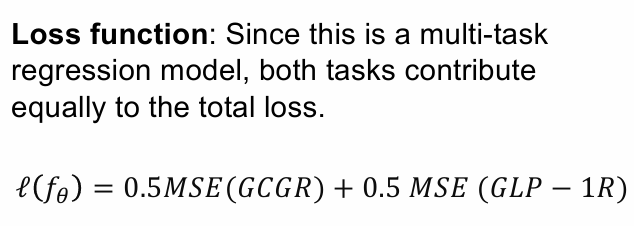

In [13]:
def multi_task_loss(y_pred, y_true):
    y1_pred, y1_true = y_pred[:, 0], y_true[:, 0]
    y2_pred, y2_true = y_pred[:, -1], y_true[:, -1]
    mse1 = nn.MSELoss()(y1_pred, y1_true)
    mse2 = nn.MSELoss()(y2_pred, y2_true)
    return 0.5 * mse1 + 0.5 * mse2

## Training

In [14]:
model = MultiHeadModel(in_shape=(21, 30))
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")


model = model.to(device)
model = model.float()
criterion = multi_task_loss
# using a gradient descsent based method for optimiztion
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

n_epochs = 1500

Total number of parameters: 649026


In [15]:
train_loss = []
val_loss = []

for epoch in tqdm.tqdm(range(n_epochs)):
    losses = train_one_epoch(model, criterion, optimizer, train_loader)
    train_loss.append(np.mean(losses))
    losses = val_one_epoch(model, criterion, test_loader)
    val_loss.append(np.mean(losses))

100%|██████████| 1500/1500 [09:23<00:00,  2.66it/s]


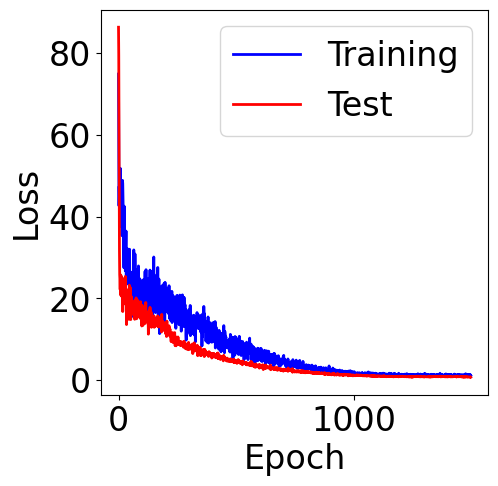

In [16]:
f, ax = plt.subplots(1, 1, figsize=(5,5))

ax.plot(train_loss, c="blue", label="Training")
ax.plot(val_loss, c="red", label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## Evaluation metrics

In [17]:
y1_true = []
y1_pred = []
y2_true = []
y2_pred = []

model.eval()
with torch.no_grad():
    for x,y in test_loader:
        if device == "cuda":
            x = x.to(device)
        x = x.float()

        y_pred = model(x)
        y1_pred.extend([y_pred[i, 0].item() for i in range(len(y_pred))])
        y2_pred.extend([y_pred[i, 1].item() for i in range(len(y_pred))])

        y = y.reshape(y_pred.shape)
        y1_true.extend([y[i, 0].item() for i in range(len(y))])
        y2_true.extend([y[i, 1].item() for i in range(len(y))])

### GCGR

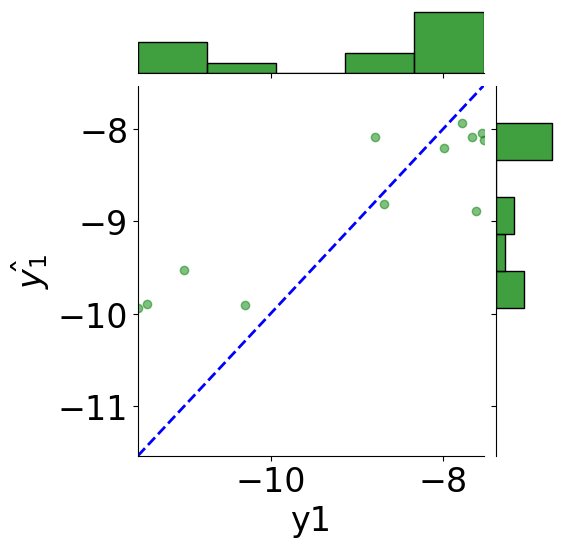

In [18]:
tmp_df = pd.DataFrame({"y1": y1_true, r"$\hat{y_1}$": y1_pred,
                       "y2": y2_true, r"$\hat{y_2}$": y2_pred})

# scatter plot
g = sns.JointGrid(x="y1", y=r"$\hat{y_1}$", data=tmp_df)
g = g.plot_joint(plt.scatter, c="green", alpha=0.5)

# line: y_pred = y
y_line = np.linspace(np.min(y1_true), np.max(y1_true), 200)
g.ax_joint.plot(y_line, y_line, color="blue", linestyle="--");

# histograms
g = g.plot_marginals(sns.histplot, data=df, color="green", kde=False)

g.ax_joint.set_xlim(np.min(y_line), np.max(y_line))
g.ax_joint.set_ylim(np.min(y_line), np.max(y_line))

plt.show()

In [19]:
print(f"MSE: {mean_squared_error(y1_true, y1_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y1_true, y1_pred):.2f}")

MSE: 0.85
Coefficient of determination: 0.64


##

### GLP-1R

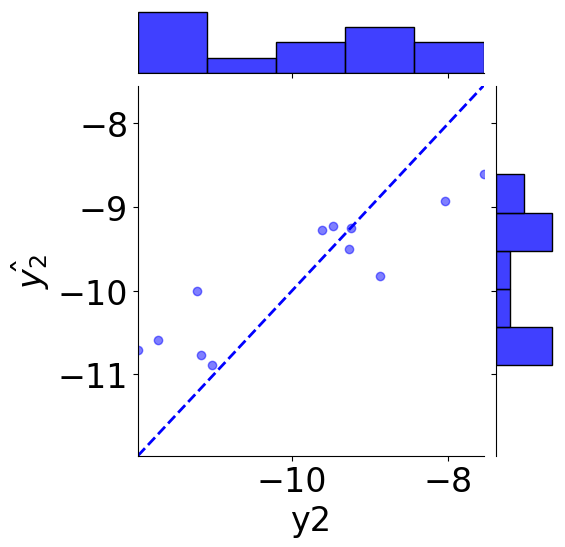

In [20]:
# scatter plot
g = sns.JointGrid(x="y2", y=r"$\hat{y_2}$", data=tmp_df)
g = g.plot_joint(plt.scatter, c="blue", alpha=0.5, label="GLP-1R")

# line: y_pred = y
y_line = np.linspace(np.min(y2_true), np.max(y2_true), 200)
g.ax_joint.plot(y_line, y_line, color="blue", linestyle="--");

# histograms
g = g.plot_marginals(sns.histplot, data=df, color="blue", kde=False)

g.ax_joint.set_xlim(np.min(y_line), np.max(y_line))
g.ax_joint.set_ylim(np.min(y_line), np.max(y_line))

plt.show()

In [21]:
print(f"MSE: {mean_squared_error(y2_true, y2_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y2_true, y2_pred):.2f}")

MSE: 0.63
Coefficient of determination: 0.67
